# Conducting a Cost-Benefit analysis growth

## Input definition
### Hazard

In [1]:
from climada.engine.impact_calc import ImpactCalc
from climada.util.api_client import Client

client = Client()
future_year = 2080
haz_present = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "historical",
        "nb_synth_tracks": "10",
    },
)
haz_future = client.get_hazard(
    "tropical_cyclone",
    properties={
        "country_name": "Haiti",
        "climate_scenario": "rcp60",
        "ref_year": str(future_year),
        "nb_synth_tracks": "10",
    },
)

ERROR 1: PROJ: proj_create_from_database: Open of /home/sjuhel/miniforge3/envs/cb_refactoring/share/proj failed
/home/sjuhel/miniforge3/envs/cb_refactoring/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


<GeoAxes: title={'center': 'TC max intensity at each point'}>

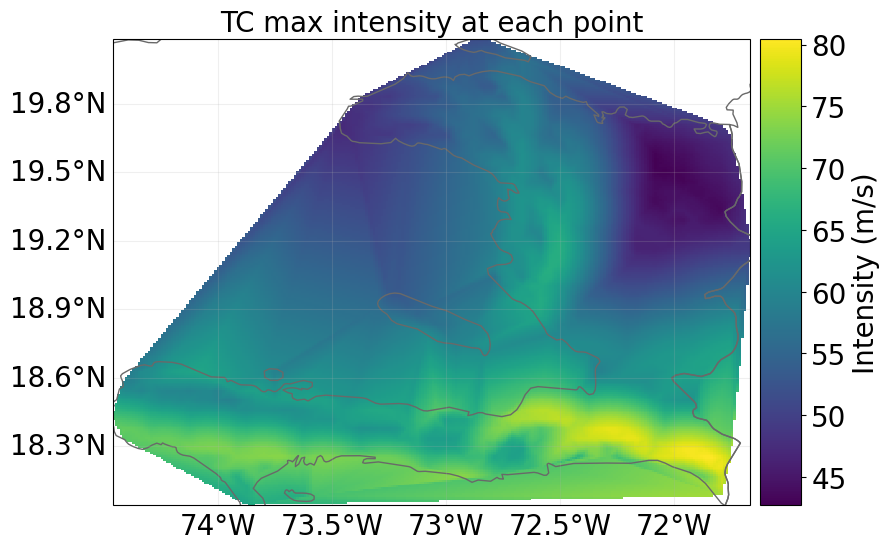

In [2]:
haz_present.plot_intensity(0)

### Exposure

In [3]:
exp_present = client.get_litpop(country="Haiti")

<GeoAxes: >

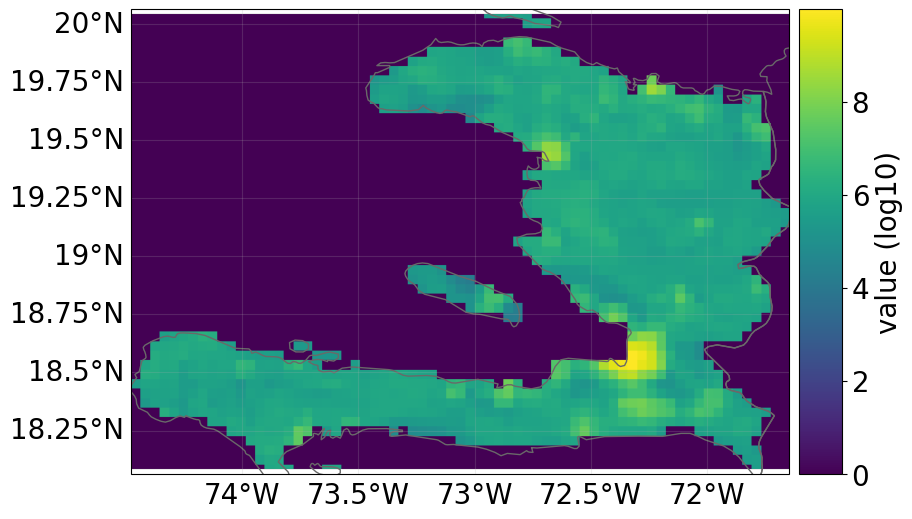

In [4]:
exp_present.plot_raster()

In [5]:
import copy

exp_future = copy.deepcopy(exp_present)
exp_future.ref_year = future_year
n_years = exp_future.ref_year - exp_present.ref_year + 1
growth_rate = 1.02
growth = growth_rate**n_years
exp_future.gdf["value"] = exp_future.gdf["value"] * growth

In [6]:
# This would be done automatically in Impact calculations
# but it's better to do it explicitly before the calculation
exp_present.assign_centroids(haz_present, distance="approx")
exp_future.assign_centroids(haz_future, distance="approx")

### Impact func

<Axes: title={'center': 'TC 1: Emanuel 2011'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

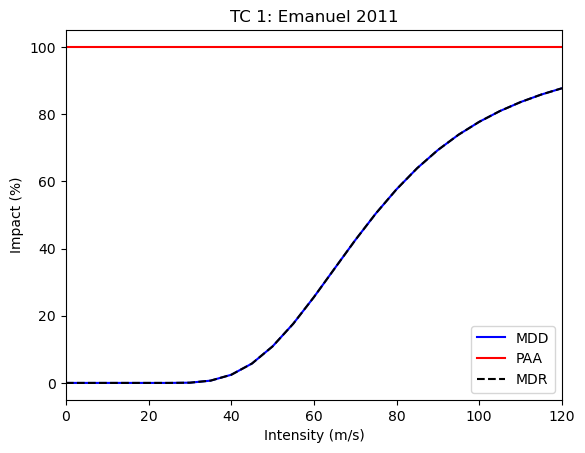

In [7]:
from climada.entity import ImpactFuncSet, ImpfTropCyclone

impf_tc = ImpfTropCyclone.from_emanuel_usa()

# add the impact function to an Impact function set
impf_set = ImpactFuncSet([impf_tc])
impf_set.check()
impf_tc.plot()

In [8]:
# Rename the impact function column in the exposures and assign hazard IDs

# This is more out of politeness, since if there's only one impact function
# and one `impf_` column, CLIMADA can figure it out
exp_present.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_present.gdf["impf_TC"] = 1
exp_future.gdf.rename(columns={"impf_": "impf_TC"}, inplace=True)
exp_future.gdf["impf_TC"] = 1

In [9]:
impc = ImpactCalc(exp_present, impf_set, haz_present)
imp = impc.impact()

<GeoAxes: title={'center': 'Expected annual impact'}>

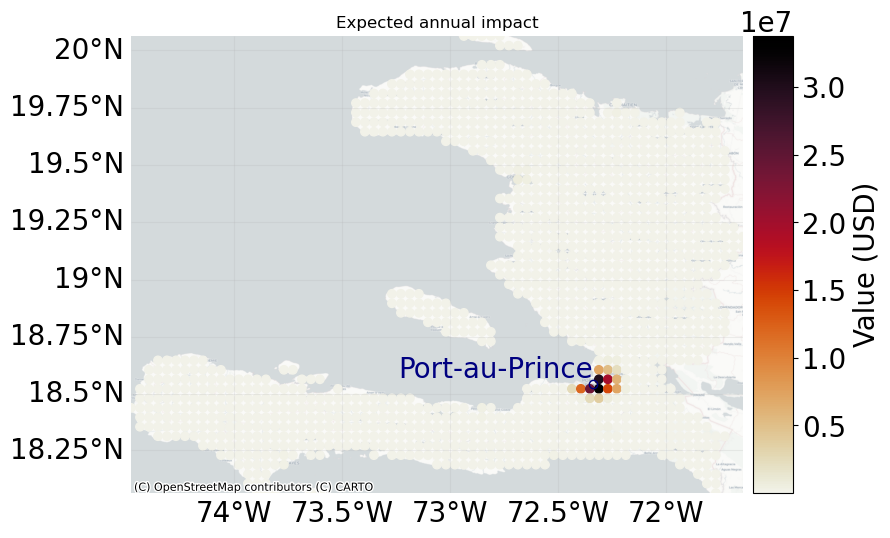

In [10]:
imp.plot_basemap_eai_exposure()

### DiscRates

In [11]:
from climada.entity import DiscRates
import numpy as np

year_range = np.arange(exp_present.ref_year, exp_future.ref_year + 1)
annual_discount_zero = np.zeros(n_years)
annual_discount_stern = np.ones(n_years) * 0.014

discount_zero = DiscRates(year_range, annual_discount_zero)
discount_stern = DiscRates(year_range, annual_discount_stern)

## Defining Snapshots (name may change)

In [12]:
from climada.engine.option_appraisal.impact_trajectories import (
    Snapshot,
    SnapshotsCollection,
    CalcImpactsSnapshots,
    RiskPeriod,
)

# Create the snapshots
snapshots = SnapshotsCollection.from_lists(
    exposure_list=[exp_present, exp_present, exp_future],
    hazard_list=[haz_present, haz_present, haz_future],
    impfset=impf_set,
    snapshot_years=[2018, 2030, 2040],
)

## Appraise options

In [13]:
from climada.engine.option_appraisal.core import (
    AdaptationPlansAppraiser,
    MeasuresAppraiser,
    YearlyRiskAppraiser,
    PlannedMeasuresAppraiser,
)

### Measures

In [14]:
# Define the measure
from climada.entity.measures.base import (
    Measure,
    helper_hazard,
    helper_impfset,
    helper_exposure,
)
from climada.entity.measures import MeasureSet
from climada.entity.measures.cost_income import CostIncome


# Measure 1
meas_1 = Measure(
    haz_type="TC",
    name="Measure A",
    hazard_change=helper_hazard(
        intensity_multiplier=1, intensity_substract=5
    ),  # Decrease wind speeds by 5 m/s
    cost_income=CostIncome(
        mkt_price_year=2018,
        init_cost=-5_000_000_000,
        annual_cost=1000,
        annual_income=500,
    ),
)

# Measure 2
meas_2 = Measure(
    haz_type="TC",
    name="Measure B",
    impfset_change=helper_impfset(
        haz_type="TC", impf_paa_modifier={1: (1, -0.10)}
    ),  # 10% fewer assets affected
    cost_income=CostIncome(
        mkt_price_year=2018, init_cost=-220_000_000, annual_cost=2000, annual_income=50
    ),
)

# gather all measures
meas_set = MeasureSet(measures=[meas_1, meas_2])

### No measure, just risk

In [15]:
risk_appraise = YearlyRiskAppraiser(snapshots, risk_disc=discount_stern)

Total per (group¹ , metric) over whole period (with or without npv)

¹: (WIP)

In [16]:
risk_appraise.calc_risk_metrics(total=True, npv=True)

,group,metric,risk,period
0,NaN,aai,6.253932e+09,2018-2040
1,NaN,rp_100,1.955937e+11,2018-2040
2,NaN,rp_1000,6.239167e+11,2018-2040
3,NaN,rp_500,6.239167e+11,2018-2040


or yearly values (will probably shift to yearly = False instead of total = True for readability)

In [17]:
risk_appraise.calc_risk_metrics()

,year,group,metric,measure,risk
0,2018,NaN,aai,no_measure,1.840432e+08
1,2019,NaN,aai,no_measure,1.815022e+08
2,2020,NaN,aai,no_measure,1.789963e+08
3,2021,NaN,aai,no_measure,1.765249e+08
4,2022,NaN,aai,no_measure,1.740877e+08
...,...,...,...,...,...
87,2036,NaN,rp_1000,no_measure,4.135670e+10
88,2037,NaN,rp_1000,no_measure,4.556938e+10
89,2038,NaN,rp_1000,no_measure,4.978608e+10
90,2039,NaN,rp_1000,no_measure,5.400410e+10


### Appraise effects of different measures of a MeasureSet (over whole period)

In [18]:
measures_appraisal = MeasuresAppraiser(
    snapshots, measure_set=meas_set, risk_disc=discount_stern, cost_disc=discount_stern
)

Risk metrics now also include with measures in effect

In [19]:
measures_appraisal.calc_risk_metrics(total=True, npv=True)

,measure,group,metric,risk,period
0,Measure A,NaN,aai,3.739497e+09,2018-2040
1,Measure A,NaN,rp_100,1.107327e+11,2018-2040
2,Measure A,NaN,rp_1000,4.904224e+11,2018-2040
3,Measure A,NaN,rp_500,4.904224e+11,2018-2040
4,Measure B,NaN,aai,5.628539e+09,2018-2040
5,Measure B,NaN,rp_100,1.760343e+11,2018-2040
6,Measure B,NaN,rp_1000,5.615251e+11,2018-2040
7,Measure B,NaN,rp_500,5.615251e+11,2018-2040
8,no_measure,NaN,aai,6.253932e+09,2018-2040
9,no_measure,NaN,rp_100,1.955937e+11,2018-2040


In addition, access to averted risk, cash flow and CB

In [20]:
measures_appraisal.calc_averted_risk(total=True, npv=True)

,measure,group,metric,averted risk,period
0,Measure A,NaN,aai,2.514435e+09,2018-2040
1,Measure A,NaN,rp_100,8.486095e+10,2018-2040
2,Measure A,NaN,rp_1000,1.334944e+11,2018-2040
3,Measure A,NaN,rp_500,1.334944e+11,2018-2040
4,Measure B,NaN,aai,6.253932e+08,2018-2040
5,Measure B,NaN,rp_100,1.955937e+10,2018-2040
6,Measure B,NaN,rp_1000,6.239167e+10,2018-2040
7,Measure B,NaN,rp_500,6.239167e+10,2018-2040
8,no_measure,NaN,aai,0.000000e+00,2018-2040
9,no_measure,NaN,rp_100,0.000000e+00,2018-2040


In [21]:
# Currently no cash_flow without npv
measures_appraisal.calc_cash_flow(total=True)

,measure,net,cost,income,period
0,Measure A,-5.000009e+09,-5.000019e+09,9911.184343,2018-2040
1,Measure B,-2.200367e+08,-2.200376e+08,991.118434,2018-2040


In [ ]:
# (already have yearly = False instead of total = True)
measures_appraisal.calc_CB(net_present_value=True, yearly=False)

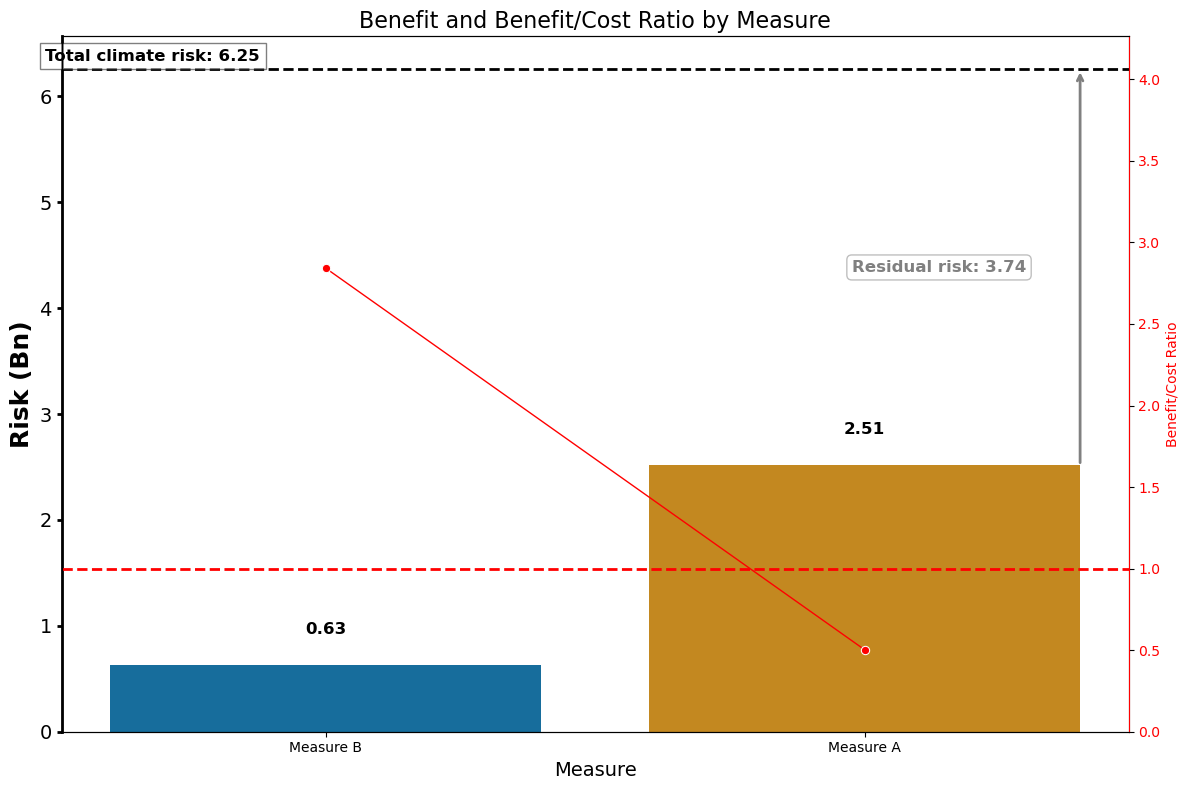

In [25]:
measures_appraisal.plot_CB_summary()

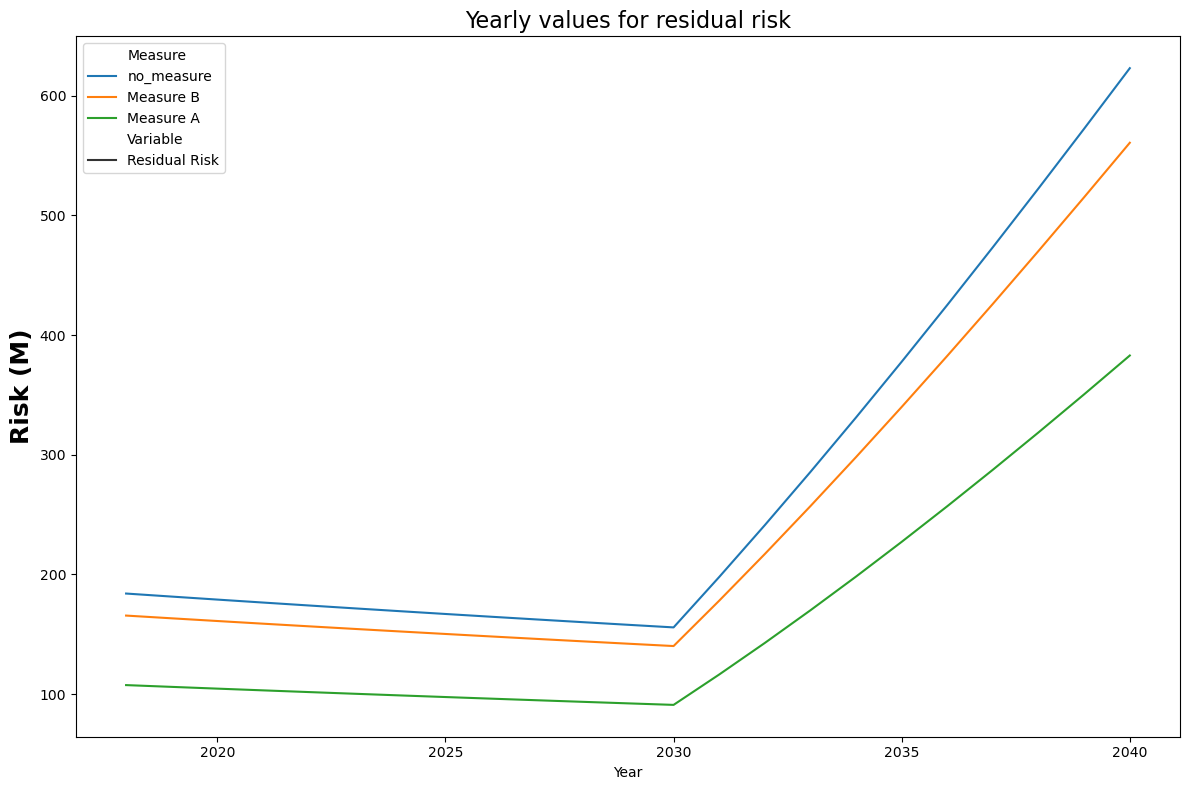

In [24]:
measures_appraisal.plot_yearly()

### Now with a planning

In [32]:
planner = {
    "Measure A": (2020, 2035),
    "Measure B": (2025, 2038),
}

In [34]:
planned_measures_appraiser = PlannedMeasuresAppraiser(
    snapshots,
    measure_set=meas_set,
    planner=planner,
    risk_disc=discount_stern,
    cost_disc=discount_stern,
)

Same attributes/methods as previously but now measures are only effective during certain years, and the possibly overlapping.
"total=True" shows results on a per distinct period basis:

In [47]:
planned_measures_appraiser.calc_risk_metrics(total=True).sort_values("period")

,measure,group,metric,risk,period
16,no_measure,NaN,rp_1000,3.831909e+10,2018-2019
18,no_measure,NaN,rp_500,3.831909e+10,2018-2019
14,no_measure,NaN,rp_100,1.135914e+10,2018-2019
12,no_measure,NaN,aai,3.655455e+08,2018-2019
0,Measure A,NaN,aai,5.088453e+08,2020-2024
1,Measure A,NaN,rp_100,1.471038e+10,2020-2024
2,Measure A,NaN,rp_1000,7.034114e+10,2020-2024
3,Measure A,NaN,rp_500,7.034114e+10,2020-2024
4,Measure A_Measure B,NaN,aai,1.278402e+09,2025-2035
5,Measure A_Measure B,NaN,rp_100,3.743099e+10,2025-2035


Note that, in CB, the cost correspond to the cost during that period (so in this exemple implementation cost of B is counted in period 2025-2035 when A and B are active)

In [26]:
planned_measures_appraiser.calc_CB()

NameError: name 'planned_measures_appraiser' is not defined

## Compare different plans

In [50]:
plans = [
    {
        "Measure A": (2020, 2035),
        "Measure B": (2025, 2038),
    },
    {
        "Measure A": (2018, 2030),
        "Measure B": (2030, 2040),
    },
    {
        "Measure A": (2020, 2040),
    },
]

In [51]:
plans_appraiser = AdaptationPlansAppraiser(
    snapshots, meas_set, plans, cost_disc=discount_stern, risk_disc=discount_stern
)

In [52]:
plans_appraiser.calc_CB()

,plan,group,metric,base risk,averted risk,residual risk,cost (net),B/C ratio
4,Measure A: 2018 - 2030 ; Measure B: 2030 - 2040 ;,No Group,aai,4.923993e+09,1.329939e+09,3.594054e+09,5.220025e+09,1.756983e+06
0,Measure A: 2020 - 2035 ; Measure B: 2025 - 2038 ;,No Group,aai,4.627017e+09,1.626916e+09,3.000101e+09,5.220032e+09,1.073726e+06
8,Measure A: 2020 - 2040 ;,No Group,aai,3.891392e+09,2.362541e+09,1.528851e+09,5.000010e+09,4.576325e+06
5,Measure A: 2018 - 2030 ; Measure B: 2030 - 2040 ;,No Group,rp_100,1.513715e+11,4.422222e+10,1.071493e+11,5.220025e+09,5.938006e+07
1,Measure A: 2020 - 2035 ; Measure B: 2025 - 2038 ;,No Group,rp_100,1.413416e+11,5.425205e+10,8.708959e+10,5.220032e+09,3.610247e+07
9,Measure A: 2020 - 2040 ;,No Group,rp_100,1.159154e+11,7.967833e+10,3.623703e+10,5.000010e+09,1.542811e+08
6,Measure A: 2018 - 2030 ; Measure B: 2030 - 2040 ;,No Group,rp_1000,5.304040e+11,9.351271e+10,4.368913e+11,5.220025e+09,1.097492e+08
2,Measure A: 2020 - 2035 ; Measure B: 2025 - 2038 ;,No Group,rp_1000,5.158709e+11,1.080459e+11,4.078250e+11,5.220032e+09,6.804409e+07
10,Measure A: 2020 - 2040 ;,No Group,rp_1000,4.992070e+11,1.247097e+11,3.744973e+11,5.000010e+09,2.408163e+08
7,Measure A: 2018 - 2030 ; Measure B: 2030 - 2040 ;,No Group,rp_500,5.304040e+11,9.351271e+10,4.368913e+11,5.220025e+09,1.097492e+08


### Access underlying plans

In [55]:
# Will probably be a dictionary (?)
plans_appraiser.plans[0].calc_CB()

,measure,period,group,metric,base risk,averted risk,residual risk,cost (net),average annual base risk,average annual residual risk,average annual averted risk,average annual cost,B/C ratio
16,no_measure,2018-2019,No Group,rp_1000,3.831909e+10,0.000000e+00,3.831909e+10,0.000000e+00,1.915954e+10,1.915954e+10,0.000000e+00,0.000000e+00,0.000000e+00
18,no_measure,2018-2019,No Group,rp_500,3.831909e+10,0.000000e+00,3.831909e+10,0.000000e+00,1.915954e+10,1.915954e+10,0.000000e+00,0.000000e+00,0.000000e+00
14,no_measure,2018-2019,No Group,rp_100,1.135914e+10,0.000000e+00,1.135914e+10,0.000000e+00,5.679569e+09,5.679569e+09,0.000000e+00,0.000000e+00,0.000000e+00
12,no_measure,2018-2019,No Group,aai,3.655455e+08,0.000000e+00,3.655455e+08,0.000000e+00,1.827727e+08,1.827727e+08,0.000000e+00,0.000000e+00,0.000000e+00
0,Measure A,2020-2024,No Group,aai,5.088453e+08,3.617614e+08,1.470838e+08,5.000002e+09,1.017691e+08,2.941677e+07,7.235228e+07,1.000000e+09,7.235226e-02
1,Measure A,2020-2024,No Group,rp_100,1.471038e+10,1.234327e+10,2.367111e+09,5.000002e+09,2.942077e+09,4.734221e+08,2.468655e+09,1.000000e+09,2.468654e+00
2,Measure A,2020-2024,No Group,rp_1000,7.034114e+10,2.092208e+10,4.941906e+10,5.000002e+09,1.406823e+10,9.883812e+09,4.184416e+09,1.000000e+09,4.184414e+00
3,Measure A,2020-2024,No Group,rp_500,7.034114e+10,2.092208e+10,4.941906e+10,5.000002e+09,1.406823e+10,9.883812e+09,4.184416e+09,1.000000e+09,4.184414e+00
4,Measure A_Measure B,2025-2035,No Group,aai,1.278402e+09,1.123046e+09,1.553557e+08,2.200250e+08,1.162183e+08,1.412324e+07,1.020951e+08,2.000227e+07,5.104176e+00
5,Measure A_Measure B,2025-2035,No Group,rp_100,3.743099e+10,3.744423e+10,-1.323766e+07,2.200250e+08,3.402817e+09,-1.203424e+06,3.404021e+09,2.000227e+07,1.701817e+02
